In [1]:
import os
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SingleFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, f)
                       for f in os.listdir(root_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
# ---------------------------
# Replay Buffer for Fake Images
# ---------------------------
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        result = []
        for element in data:
            element = torch.unsqueeze(element.data, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if torch.rand(1) < 0.5:
                    idx = torch.randint(0, len(self.data), (1,)).item()
                    result.append(self.data[idx].clone())
                    self.data[idx] = element
                else:
                    result.append(element)
        return torch.cat(result)

In [4]:
# ---------------------------
# Self-Attention Block (SAGAN-inspired)
# ---------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)  # softmax over the last dimension

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        # Generate query, key, and value matrices
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)  # (B, N, C//8)
        proj_key   = self.key_conv(x).view(m_batchsize, -1, width * height)  # (B, C//8, N)
        energy = torch.bmm(proj_query, proj_key)  # (B, N, N)
        attention = self.softmax(energy)  # (B, N, N)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)  # (B, C, N)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # (B, C, N)
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma * out + x
        return out

In [5]:
#   Network Architectures
# ---------------------------
# Residual Block for the Generator
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# ResNet-based Generator (used for both directions)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_residual_blocks=12):
        super(ResnetGenerator, self).__init__()
        # Initial Convolution Block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual Blocks with Self-Attention inserted halfway
        res_blocks = []
        for i in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(in_features))
            # Insert self-attention block at halfway point
            if i == num_residual_blocks // 2:
                res_blocks.append(SelfAttention(in_features))
        model += res_blocks

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output Layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            spectral_norm(nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        model += [
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        model += [
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        model += [
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        # Final output 1-channel prediction map
        model += [spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


# VGG-based feature extractor for perceptual loss
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35, use_input_norm=True):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19.features.children())[:feature_layer]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.use_input_norm = use_input_norm
        if self.use_input_norm:
            # Register buffers for normalization (VGG expects inputs in [0,1])
            self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    def forward(self, x):
        if self.use_input_norm:
            # Scale from [-1, 1] to [0, 1]
            x = (x + 1) / 2
            x = (x - self.mean) / self.std
        return self.feature_extractor(x)

In [6]:
#         Losses
# For adversarial loss we use LSGAN loss (Mean Squared Error)
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
criterion_perceptual = nn.L1Loss()

def real_target_tensor(input):
    return torch.ones_like(input)

def fake_target_tensor(input):
    return torch.zeros_like(input)

In [7]:
torch.cuda.empty_cache()
import gc
gc.collect()

6

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/200] Batch [0] Loss_G: 8.3110 Loss_D_A: 0.7108 Loss_D_B: 1.6295
Epoch [0/200] Batch [100] Loss_G: 4.1579 Loss_D_A: 0.2323 Loss_D_B: 0.3391
Epoch [1/200] Batch [0] Loss_G: 4.6897 Loss_D_A: 0.3057 Loss_D_B: 0.2435
Epoch [1/200] Batch [100] Loss_G: 4.0673 Loss_D_A: 0.8487 Loss_D_B: 0.3264
Epoch [2/200] Batch [0] Loss_G: 4.3432 Loss_D_A: 0.2385 Loss_D_B: 0.3646
Epoch [2/200] Batch [100] Loss_G: 4.0934 Loss_D_A: 0.3074 Loss_D_B: 0.2443
Epoch [3/200] Batch [0] Loss_G: 3.9120 Loss_D_A: 0.2717 Loss_D_B: 0.2495
Epoch [3/200] Batch [100] Loss_G: 4.4658 Loss_D_A: 0.2443 Loss_D_B: 0.2021
Epoch [4/200] Batch [0] Loss_G: 3.5379 Loss_D_A: 0.3974 Loss_D_B: 0.2345
Epoch [4/200] Batch [100] Loss_G: 3.7503 Loss_D_A: 0.3029 Loss_D_B: 0.2792
Epoch [5/200] Batch [0] Loss_G: 3.8773 Loss_D_A: 0.2301 Loss_D_B: 0.2516
Epoch [5/200] Batch [100] Loss_G: 3.5680 Loss_D_A: 0.2052 Loss_D_B: 0.2337
Epoch [6/200] Batch [0] Loss_G: 3.4048 Loss_D_A: 0.3153 Loss_D_B: 0.3205
Epoch [6/200] Batch [100] Loss_G: 3.400

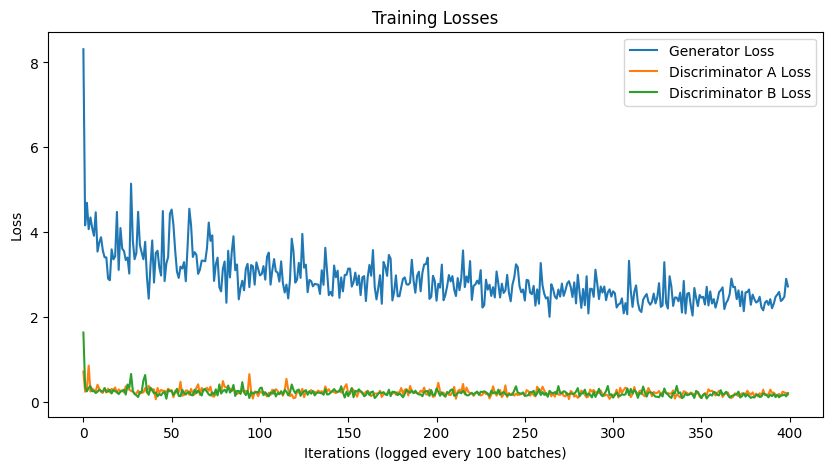

In [8]:
import os
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.utils import spectral_norm

torch.multiprocessing.set_sharing_strategy('file_system')


# ---------------------------
# Training Function
# ---------------------------
def train():
    # Hyperparameters
    num_epochs = 200
    batch_size = 2
    lr = 0.0015
    image_size = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize networks
    netG_A2B = ResnetGenerator(input_nc=3, output_nc=3, num_residual_blocks=14).to(device)
    netG_B2A = ResnetGenerator(input_nc=3, output_nc=3, num_residual_blocks=14).to(device)
    netD_A = Discriminator(input_nc=3).to(device)
    netD_B = Discriminator(input_nc=3).to(device)

    # VGG for perceptual loss
    vgg = VGGFeatureExtractor(feature_layer=35).to(device)

    # Optimizers
    optimizer_G = optim.Adam(
        itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(0.5, 0.999)
    )
    optimizer_D_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

    # Learning Rate Schedulers – linear decay after half the epochs
    lr_lambda = lambda epoch: 1.0 - max(0, epoch - num_epochs/2) / (num_epochs/2)
    scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
    scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
    scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)


    # Data Transforms
    transform = transforms.Compose([
        transforms.Resize(int(image_size * 1.12), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create datasets using the custom SingleFolderDataset
    dataset_A = SingleFolderDataset(root_dir="photo_jpg", transform=transform)
    dataset_B = SingleFolderDataset(root_dir="monet_jpg", transform=transform)

    dataloader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=0)
    dataloader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=0)

    # Lists for logging losses (optional for plotting later)
    loss_G_list = []
    loss_D_A_list = []
    loss_D_B_list = []

     # Initialize replay buffers for fake images
    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()

    # Training Loop
    for epoch in range(num_epochs):
        for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
            real_A = data_A.to(device)
            real_B = data_B.to(device)

            # Loss weights (adjusted to reduce overall generator loss)
            lambda_identity = 3.0
            lambda_cycle = 1.0       # Reduced from 10.0
            lambda_perceptual = 0.3  # Reduced from 1.0

            # ------------------ Train Generators ------------------
            optimizer_G.zero_grad()
            same_B = netG_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B) * lambda_identity
            same_A = netG_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A) * lambda_identity

            fake_B = netG_A2B(real_A)
            pred_fake_B = netD_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake_B, real_target_tensor(pred_fake_B).to(device))

            fake_A = netG_B2A(real_B)
            pred_fake_A = netD_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake_A, real_target_tensor(pred_fake_A).to(device))

            rec_A = netG_B2A(fake_B)
            loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_cycle
            rec_B = netG_A2B(fake_A)
            loss_cycle_B = criterion_cycle(rec_B, real_B) * lambda_cycle

            features_real_A = vgg(real_A)
            features_fake_B = vgg(fake_B)
            loss_perceptual_A2B = criterion_perceptual(features_fake_B, features_real_A) * lambda_perceptual
            features_real_B = vgg(real_B)
            features_fake_A = vgg(fake_A)
            loss_perceptual_B2A = criterion_perceptual(features_fake_A, features_real_B) * lambda_perceptual

            loss_G = (loss_identity_A + loss_identity_B +
            loss_GAN_A2B + loss_GAN_B2A +
            loss_cycle_A + loss_cycle_B +
            loss_perceptual_A2B + loss_perceptual_B2A)

            loss_G.backward()
            optimizer_G.step()

            # ------------------ Train Discriminator A ------------------
            optimizer_D_A.zero_grad()
            pred_real_A = netD_A(real_A)
            loss_D_real_A = criterion_GAN(pred_real_A, real_target_tensor(pred_real_A).to(device))
            fake_A_buffered = fake_A_buffer.push_and_pop(fake_A.detach())
            pred_fake_A = netD_A(fake_A_buffered)
            loss_D_fake_A = criterion_GAN(pred_fake_A, fake_target_tensor(pred_fake_A).to(device))
            loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # ------------------ Train Discriminator B ------------------
            optimizer_D_B.zero_grad()
            pred_real_B = netD_B(real_B)
            loss_D_real_B = criterion_GAN(pred_real_B, real_target_tensor(pred_real_B).to(device))
            fake_B_buffered = fake_B_buffer.push_and_pop(fake_B.detach())
            pred_fake_B = netD_B(fake_B_buffered)
            loss_D_fake_B = criterion_GAN(pred_fake_B, fake_target_tensor(pred_fake_B).to(device))
            loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] Loss_G: {loss_G.item():.4f} "
                      f"Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")
                loss_G_list.append(loss_G.item())
                loss_D_A_list.append(loss_D_A.item())
                loss_D_B_list.append(loss_D_B.item())

        # Step the learning rate schedulers at the end of each epoch
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()


    # Save model checkpoints after training
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(netG_A2B.state_dict(), "checkpoints/netG_A2B.pth")
    torch.save(netG_B2A.state_dict(), "checkpoints/netG_B2A.pth")
    torch.save(netD_A.state_dict(), "checkpoints/netD_A.pth")
    torch.save(netD_B.state_dict(), "checkpoints/netD_B.pth")
    print("MODELS SAVED")
    # Optionally, plot losses after training
    plt.figure(figsize=(10, 5))
    plt.plot(loss_G_list, label="Generator Loss")
    plt.plot(loss_D_A_list, label="Discriminator A Loss")
    plt.plot(loss_D_B_list, label="Discriminator B Loss")
    plt.xlabel("Iterations (logged every 100 batches)")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.show()

    # Return trained generators for later inference
    return netG_A2B, netG_B2A, device

# ---------------------------
# Inference Function to Generate Exactly 1000 Images
# ---------------------------
def generate_images(netG, dataset, num_images=1000, output_dir="output", device=None):
    netG.eval()  # Set the generator to evaluation mode
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
    os.makedirs(output_dir, exist_ok=True)
    saved = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            real_image = data.to(device)
            fake_image = netG(real_image)
            save_image(fake_image, os.path.join(output_dir, f"generated_{saved}.jpg"), normalize=True)
            saved += 1
            if saved >= num_images:
                break
    print(f"Generated {saved} images in '{output_dir}'.")

# ---------------------------
# Main Script
# ---------------------------
if __name__ == "__main__":
    # Train the model completely for 200 epochs
    netG_A2B, netG_B2A, device = train()

    # Now, run a separate inference loop to generate exactly 1000 images.
    # For example, using real photos as input to generate Monet-style outputs:
    transform_inference = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [9]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
inference_dataset = SingleFolderDataset(root_dir="photo_jpg", transform=transform_inference)
generate_images(netG_A2B, inference_dataset, num_images=1000, output_dir="output", device=device)

Generated 1000 images in 'output'.


In [14]:
pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 54.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 33.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import scipy.linalg
from scipy.spatial.distance import cosine
import math
from PIL import Image
import os
from tqdm import tqdm
import random
import pandas as pd

# Set the random seed for reproducibility
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define paths for local machine
REAL_MONET_PATH = "Eval"  # Update with actual path for real Monet images
GENERATED_MONET_PATH = "output"  # Update with actual path for generated Monet images
batch_size = 64

# Set a random seed for reproducibility
set_random_seed(42)

In [16]:
# Helper function to load images
def load_images(image_paths, transform):
    images = []
    for path in image_paths:
        image = Image.open(path).convert('RGB')

        # Ensure images are 256x256
        if image.size != (256, 256):
            raise ValueError(f"Image {path} is not 256x256 in size.")

        # Ensure images are in .jpg format
        if not path.lower().endswith('.jpg'):
            raise ValueError(f"Image {path} is not in .jpg format.")

        image = transform(image)
        images.append(image)

    return torch.stack(images)

# Helper function to calculate activations using InceptionV3
def calculate_activations(images, model, device):
    images = images.to(device)
    with torch.no_grad():
        features = model(images)
    return features.cpu().numpy()

In [17]:
# Function to subsample the larger dataset (real or generated)
def subsample_datasets(real_image_paths, generated_image_paths):
    # Determine the smaller and larger dataset
    real_count = len(real_image_paths)
    generated_count = len(generated_image_paths)

    if real_count > generated_count:
        # Subsample the real images to match the number of generated images
        print(f"Subsampling real images from {real_count} to {generated_count}")
        real_image_paths = random.sample(real_image_paths, generated_count)
    elif generated_count > real_count:
        # Subsample the generated images to match the number of real images
        print(f"Subsampling generated images from {generated_count} to {real_count}")
        generated_image_paths = random.sample(generated_image_paths, real_count)

    return real_image_paths, generated_image_paths

In [18]:
# Function to compute FID and MiFID
def calculate_mifid(real_image_paths, generated_image_paths, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load InceptionV3 model
    inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    inception.fc = nn.Identity()  # Remove classification layer
    inception.eval()
    inception = inception.to(device)

    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize(int(256 * 1.33)),  # Resize with scaling
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet stats
    ])

    # Subsample datasets if needed
    real_image_paths, generated_image_paths = subsample_datasets(real_image_paths, generated_image_paths)

    # Process real images in batches
    real_activations = []
    for i in tqdm(range(0, len(real_image_paths), batch_size), desc="Processing Real Images"):
        batch_paths = real_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        real_activations.append(calculate_activations(batch_images, inception, device))
    real_activations = np.concatenate(real_activations, axis=0)

    # Process generated images in batches
    generated_activations = []
    for i in tqdm(range(0, len(generated_image_paths), batch_size), desc="Processing Generated Images"):
        batch_paths = generated_image_paths[i:i+batch_size]
        batch_images = load_images(batch_paths, transform)
        generated_activations.append(calculate_activations(batch_images, inception, device))
    generated_activations = np.concatenate(generated_activations, axis=0)

    # Calculate mean and covariance
    real_mu = np.mean(real_activations, axis=0)
    generated_mu = np.mean(generated_activations, axis=0)
    real_sigma = np.cov(real_activations, rowvar=False)
    generated_sigma = np.cov(generated_activations, rowvar=False)

    # Compute FID
    diff = real_mu - generated_mu
    covmean, _ = scipy.linalg.sqrtm(real_sigma.dot(generated_sigma), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(real_sigma + generated_sigma - 2 * covmean)

    # Calculate MiFID
    # Calculate the memorization distance between each generated image and the real images
    memorization_distances = [
        min([cosine(g_feat, r_feat) for r_feat in real_activations])
        for g_feat in generated_activations
    ]
    # Calculate the MiFID as the mean memorization distance
    mifid = np.mean(memorization_distances)

    print(f"MiFID Score: {mifid}")
    return fid, mifid

In [19]:
# Main function for evaluation
def evaluate():
    # Get list of real and generated images
    real_image_paths = sorted([os.path.join(REAL_MONET_PATH, f) for f in os.listdir(REAL_MONET_PATH) if f.endswith('.jpg')])
    generated_image_paths = sorted([os.path.join(GENERATED_MONET_PATH, f) for f in os.listdir(GENERATED_MONET_PATH) if f.endswith('.jpg')])

    # Check that there are more than 300 generated images
    if len(generated_image_paths) < 300:
        raise ValueError("The number of generated images should be greater than 300.")

    # Compute FID and MiFID scores
    fid_score, mifid_score = calculate_mifid(real_image_paths, generated_image_paths, batch_size=batch_size)

    # Save results to CSV
    result_df = pd.DataFrame({
        'ID': [1],
        'FID': [fid_score],
        'MiFID': [mifid_score]
    })

    result_df.to_csv('submission.csv', index=False)
    print(result_df)
    print("Results saved to 'submission.csv'")

# Run the evaluation
if __name__ == "__main__":
    evaluate()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 69.0MB/s] 


Subsampling generated images from 1000 to 933


Processing Generated Images: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


MiFID Score: 0.22069771968192775
   ID        FID     MiFID
0   1  50.417772  0.220698
Results saved to 'submission.csv'
